In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
import numpy as np
import sys
sys.path.append("/n/home03/creissel/phlab-neurips25")
from models.networks import MLP

# 1. Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels, balance=True):
        if balance:
            self.data = data[:32000]
            self.labels = labels[:32000]
        else:
            self.data = data
            self.labels = labels
        print(data.shape)
        print(labels.shape)
        #self.labels = (labels == 6).int()
        print(np.sum(self.labels.numpy()))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 2. Define the model
model = MLP(4,[32,32,32,32],1,activation='relu', output_activation='sigmoid')

# 3. Instantiate the model, loss function, and optimizer
learning_rate = 0.001
num_epochs = 10
batch_size = 128

# Load data
path = '/n/holystore01/LABS/iaifi_lab/Lab/phlab-neurips25/GWAK/results/'
train = np.load(path+'train.npz')
test = np.load(path+'test.npz')
anomaly = np.load(path+'anomaly.npz')

# Create the dataset and dataloader
bkg = CustomDataset(torch.tensor(train['data']), torch.tensor(np.zeros(train['data'].shape[0])).long())
sig = CustomDataset(torch.tensor(anomaly['data']), torch.tensor(np.ones(anomaly['data'].shape[0])).long())
generator = torch.Generator().manual_seed(42)
sig_train, sig_test = random_split(sig, [0.7,0.3], generator=generator)
dataset = ConcatDataset([bkg,sig_train])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print('Background samples used:', len(bkg))
print('Signal samples used:', len(sig))
#dataset = CustomDataset(torch.tensor(train['data']), torch.tensor(train['label']).long())
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 4. Training loop
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(dataloader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.flatten().float(), labels.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(dataloader), loss.item()))

# 5. Save the model (optional)
#torch.save(model.state_dict(), 'model.pth')

torch.Size([448037, 4])
torch.Size([448037])
0
torch.Size([32000, 4])
torch.Size([32000])
32000
Background samples used: 32000
Signal samples used: 32000
Epoch [1/10], Step [100/425], Loss: 0.4446
Epoch [1/10], Step [200/425], Loss: 0.4533
Epoch [1/10], Step [300/425], Loss: 0.4779
Epoch [1/10], Step [400/425], Loss: 0.4804
Epoch [2/10], Step [100/425], Loss: 0.4362
Epoch [2/10], Step [200/425], Loss: 0.4566
Epoch [2/10], Step [300/425], Loss: 0.4849
Epoch [2/10], Step [400/425], Loss: 0.4899
Epoch [3/10], Step [100/425], Loss: 0.4746
Epoch [3/10], Step [200/425], Loss: 0.4779
Epoch [3/10], Step [300/425], Loss: 0.4475
Epoch [3/10], Step [400/425], Loss: 0.4802
Epoch [4/10], Step [100/425], Loss: 0.4279
Epoch [4/10], Step [200/425], Loss: 0.4744
Epoch [4/10], Step [300/425], Loss: 0.5407
Epoch [4/10], Step [400/425], Loss: 0.4904
Epoch [5/10], Step [100/425], Loss: 0.4919
Epoch [5/10], Step [200/425], Loss: 0.4312
Epoch [5/10], Step [300/425], Loss: 0.4271
Epoch [5/10], Step [400/425],

In [16]:
from tqdm import tqdm

def evaluation(dataloader, model):
    output = []
    labels = []
    for data,labs in tqdm(dataloader):
        labels.append(labs)
        with torch.no_grad():
            #output.append(model(ims.to(device),embed=True).cpu().numpy())
            output.append(model(data).cpu().numpy())
    labels = np.array(labels)
    output = np.concatenate(output, axis=0)
    return labels, output

In [22]:
sig_truth, sig_predict = evaluation(sig_test, model)
bkg_test = CustomDataset(torch.tensor(test['data']), torch.tensor(np.zeros(test['data'].shape[0])).long(), balance=False)
bkg_truth, bkg_predict = evaluation(bkg_test, model)
#test_dset = CustomDataset(torch.tensor(test['data']), torch.tensor(test['label']).long())
#test_truth, test_predict = evaluation(test_dset, model)

100%|██████████| 9600/9600 [00:00<00:00, 11291.31it/s]


torch.Size([49781, 4])
torch.Size([49781])
0


100%|██████████| 49781/49781 [00:04<00:00, 11098.15it/s]


In [23]:
from sklearn.metrics import roc_curve, auc
comb_label = np.append(sig_truth, bkg_truth)
comb_pred = np.append(sig_predict, bkg_predict)
#comb_label = test_truth
#comb_pred = test_predict

In [24]:
comb_pred

array([8.0786198e-01, 6.3324493e-01, 4.7227246e-01, ..., 8.2984370e-05,
       3.8150864e-04, 4.0657151e-01], shape=(59381,), dtype=float32)

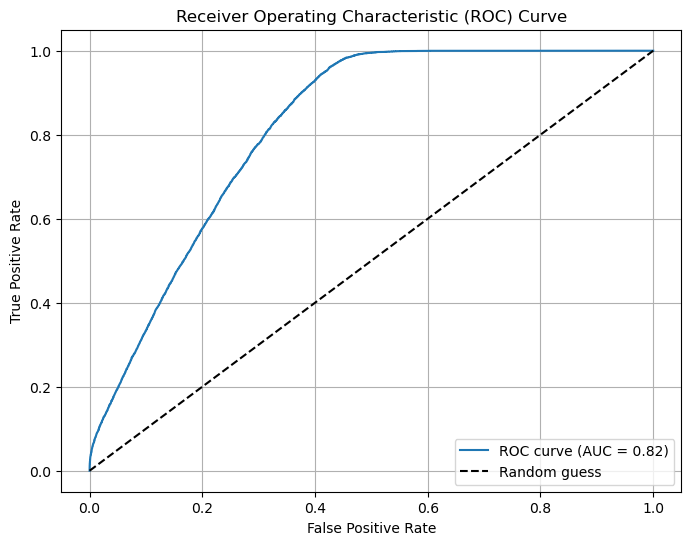

In [25]:
fpr, tpr, thresholds = roc_curve(comb_label, comb_pred)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
# 6. Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [26]:
path = '/n/holystore01/LABS/iaifi_lab/Lab/phlab-neurips25/GWAK/results/classifier/'
np.savez(path+'classifier_woAnomaly_classbalanced.npz', predict=comb_pred, label=comb_label)